# Image size 

Review the MRI brain tumor segmentation dataset

In [20]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import matplotlib.pyplot as plt
import torch.distributed as dist
import torch.multiprocessing as mp
import torchvision.transforms.functional as TF
from torch.utils.data import random_split


Image: 1231.png, Width: 512, Height: 512


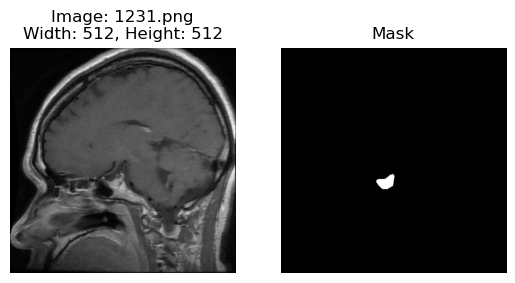

In [37]:

def get_image_size(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    if image is not None:
        height, width = image.shape[:2]
        return width, height
    else:
        return None

image_folder_path = '/kaggle/input/brain-tumor-segmentation/images'
mask_folder_path = '/kaggle/input/brain-tumor-segmentation/masks'

image_files = os.listdir(image_folder_path)

if len(image_files) > 0:
    image_file = image_files[2]

    image_path = os.path.join(image_folder_path, image_file)
    mask_file = image_file  # Assuming mask file names are the same as image file names
    mask_path = os.path.join(mask_folder_path, mask_file)

    image_size = get_image_size(image_path)

    if image_size is not None:
        print(f"Image: {image_file}, Width: {image_size[0]}, Height: {image_size[1]}")

        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(f"Image: {image_file}\nWidth: {image_size[0]}, Height: {image_size[1]}")
        plt.axis('off')

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap='gray')
        plt.title("Mask")
        plt.axis('off')

        plt.show()
    else:
        print(f"Failed to read the image: {image_file}")
else:
    print("No images found in the specified folder.")

# U Net model

In [38]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

In [39]:
class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [40]:
def test():
    x = torch.randn((3,1, 160, 160))
    model = UNET(in_channels = 1, out_channels = 1)
    if torch.cuda.device_count() > 1:
        print("Using DataParallel with", torch.cuda.device_count(), "GPU")
        model = nn.DataParallel(model)
        
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    preds = model(x)

    print(preds.shape)
    print(x.shape)
    assert preds.shape == x.shape
    
if __name__ == "__main__":
    test()

Using DataParallel with 2 GPU
torch.Size([3, 1, 160, 160])
torch.Size([3, 1, 160, 160])


# Load dataset

In [41]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        mask_path = self.mask_paths[index]

        image = Image.open(image_path).convert("RGB")  # Convert to RGB if needed
        mask = Image.open(mask_path).convert("L")  # Convert to grayscale mask

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

In [42]:
def create_data_loaders(train_image_paths, train_mask_paths, test_image_paths, test_mask_paths, batch_size=16, validation_split=None):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])

    train_dataset = CustomDataset(train_image_paths, train_mask_paths, transform=transform)

    if validation_split is not None:
        num_samples = len(train_dataset)
        val_size = int(validation_split * num_samples)
        train_size = num_samples - val_size

        train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

        test_dataset = CustomDataset(test_image_paths, test_mask_paths, transform=transform)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

        return train_loader, val_loader, test_loader

    else:
        test_dataset = CustomDataset(test_image_paths, test_mask_paths, transform=transform)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

        return train_loader, test_loader

In [43]:
def train_unet(model, train_loader, val_loader, criterion, optimizer, num_epochs=5, writer=None, early_stopping=None):
    model.train()
    loss_values = []
    val_loss_values = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, masks in train_loader:
            optimizer.zero_grad()

            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        loss_values.append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}")

        if writer is not None:
            writer.add_scalar("Loss/Train", epoch_loss, epoch)

        val_loss = validate_model(model, val_loader, criterion, device)
        val_loss_values.append(val_loss)
        
        if writer is not None:
            writer.add_scalar("Loss/Validation", val_loss, epoch)

        print(f"Validation Loss: {val_loss}")

        if early_stopping is not None:
            early_stop = early_stopping(val_loss, model)  # Call early stopping

            if early_stop:
                print("Early stopping triggered.")
                model.load_state_dict(early_stopping.best_model_weights)
                break

    return loss_values, val_loss_values



def validate_model(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss.item()

    val_loss = total_loss / len(val_loader)

    return val_loss


class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.best_model_weights = None

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model_weights = model.state_dict()
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop


In [47]:
def visualize_images(image, mask, prediction):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    image = image.squeeze().permute(1, 2, 0).cpu().numpy()
    mask = mask.squeeze().cpu().numpy()
    prediction = prediction.squeeze().cpu().numpy()

    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(mask, cmap="gray")
    axes[1].set_title("Ground Truth Mask")
    axes[1].axis("off")

    axes[2].imshow(prediction, cmap="gray")
    axes[2].set_title("Predicted Mask")
    axes[2].axis("off")

    plt.show()

# Train and test

In [56]:
if __name__ == "__main__":
    image_folder = '/kaggle/input/brain-tumor-segmentation/images'
    mask_folder = '/kaggle/input/brain-tumor-segmentation/masks'
    
    image_paths = [os.path.join(image_folder, img) for img in os.listdir(image_folder)]
    mask_paths = [os.path.join(mask_folder, mask) for mask in os.listdir(mask_folder)]

    num_samples = len(image_paths)
    train_size = int(0.8 * num_samples)  # 80% for training and validation, 20% for testing
    val_size = (num_samples - train_size) // 2
    indices = np.random.permutation(num_samples)
    train_indices, val_indices, test_indices = indices[:train_size], indices[train_size:train_size+val_size], indices[train_size+val_size:]

    train_image_paths = [image_paths[i] for i in train_indices]
    train_mask_paths = [mask_paths[i] for i in train_indices]
    val_image_paths = [image_paths[i] for i in val_indices]
    val_mask_paths = [mask_paths[i] for i in val_indices]
    test_image_paths = [image_paths[i] for i in test_indices]
    test_mask_paths = [mask_paths[i] for i in test_indices]

    in_channels = 3
    out_channels = 1
    model = UNET(in_channels, out_channels)
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy loss for binary segmentation
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_loader, val_loader, test_loader = create_data_loaders(train_image_paths, train_mask_paths, val_image_paths, val_mask_paths, batch_size=16, validation_split=0.2)

    num_epochs = 25
    early_stopping = EarlyStopping(patience=3, verbose=True)  # Set patience to 5
    loss_values, val_loss_values = train_unet(model, train_loader, val_loader, criterion, optimizer, num_epochs, early_stopping=early_stopping)


Epoch 1/25, Loss: 0.1777601601873956
Validation Loss: 0.09481955944530425
Epoch 2/25, Loss: 0.06995494345702775
Validation Loss: 0.06986550205657559
Epoch 3/25, Loss: 0.06287800160244228
Validation Loss: 0.06581425943201588
Epoch 4/25, Loss: 0.05632941176493963
Validation Loss: 0.05935685612982319
Epoch 5/25, Loss: 0.051994670227896875
Validation Loss: 0.050388268285220666
Epoch 6/25, Loss: 0.048802861746976046
Validation Loss: 0.04462561762380984
Epoch 7/25, Loss: 0.04466271930472637
Validation Loss: 0.03947163241044167
Epoch 8/25, Loss: 0.04059652981113612
Validation Loss: 0.04236489696608436
Epoch 9/25, Loss: 0.038963443107478984
Validation Loss: 0.03879031929517946
Epoch 10/25, Loss: 0.035860078409314156
Validation Loss: 0.03403778362178033
Epoch 11/25, Loss: 0.03215014198567809
Validation Loss: 0.03428510744725504
Epoch 12/25, Loss: 0.032280391824196994
Validation Loss: 0.03058247172063397
Epoch 13/25, Loss: 0.030461011870908057
Validation Loss: 0.03281261645738156
Epoch 14/25, Lo

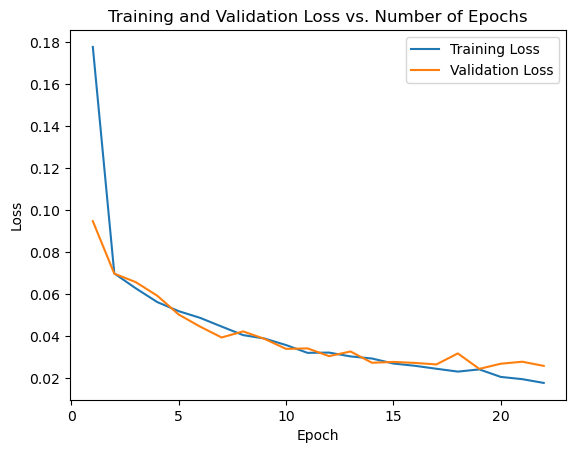

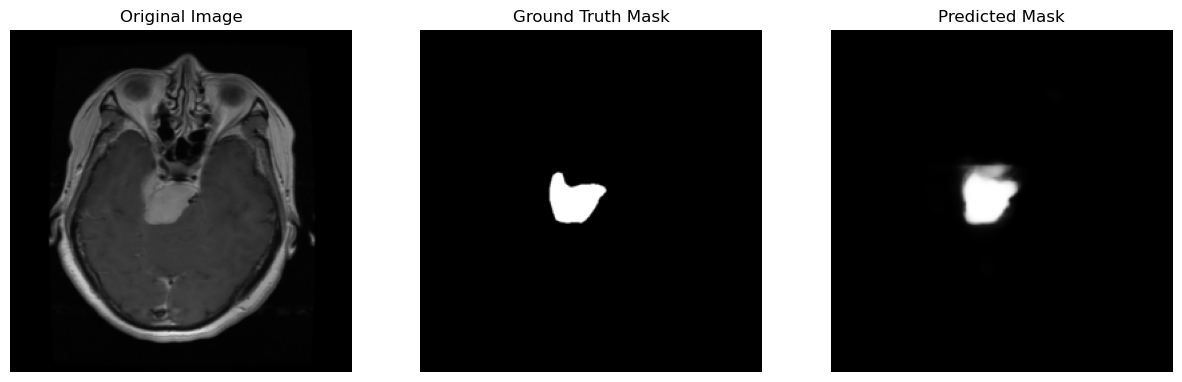

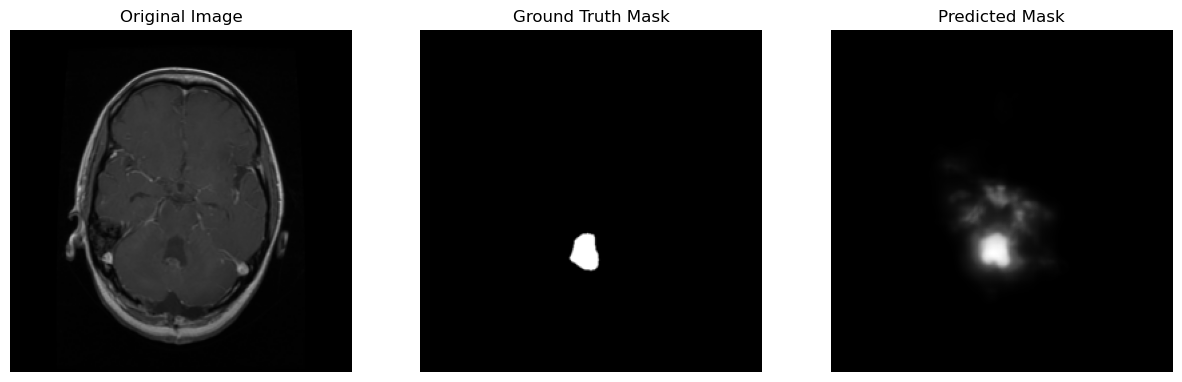

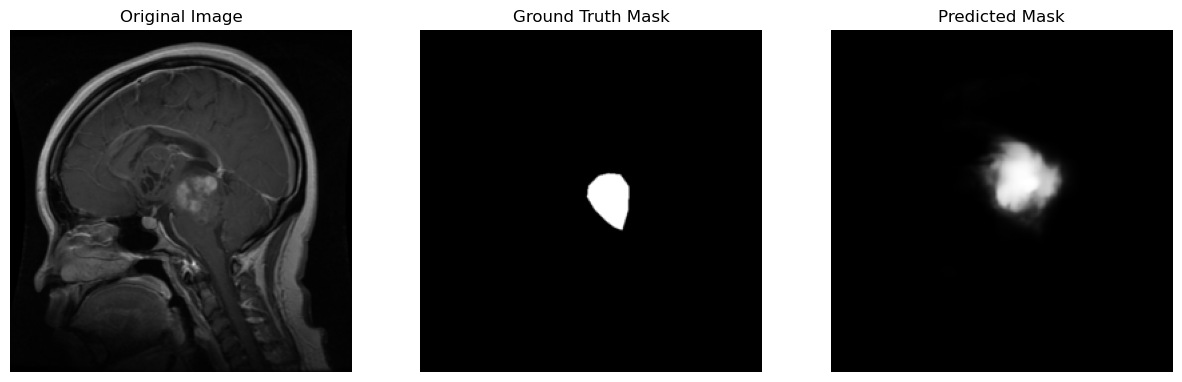

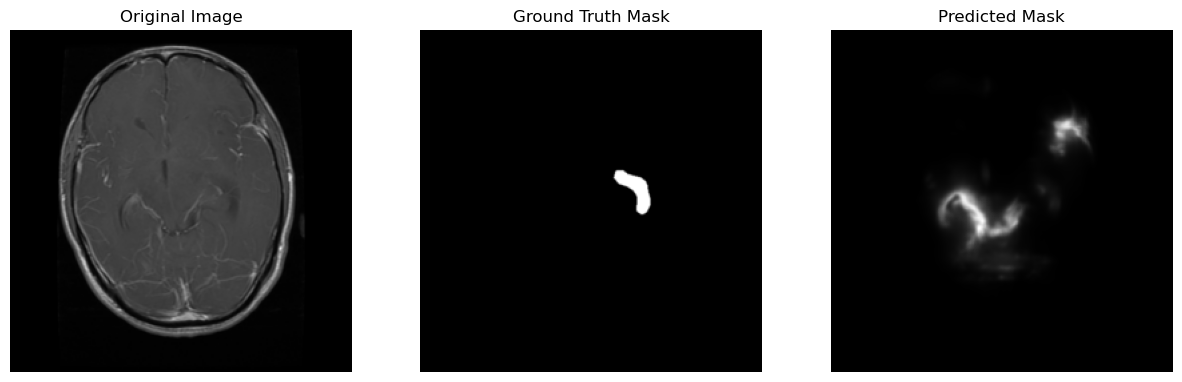

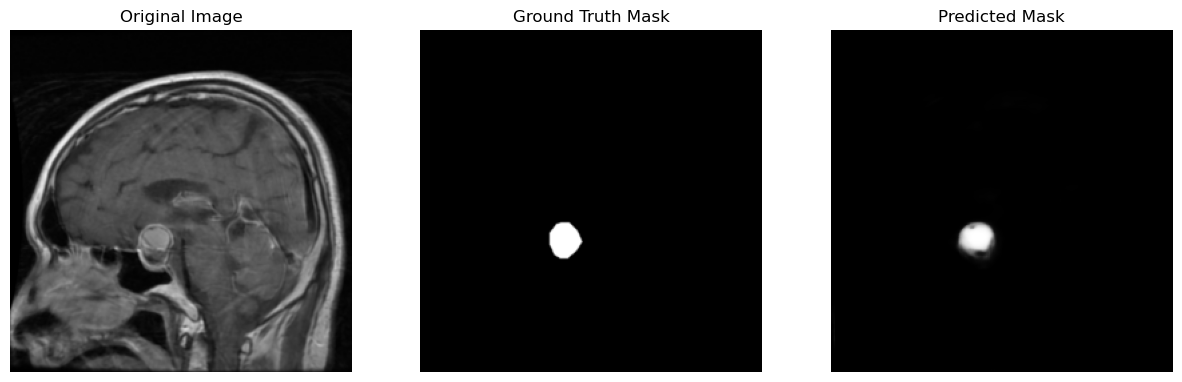

In [58]:
    plt.plot(range(1,len(loss_values)+1),loss_values, label="Training Loss")
    plt.plot(range(1,len(loss_values)+1), val_loss_values, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss vs. Number of Epochs")
    plt.legend()
    plt.show()

    
    num_images_to_visualize = 5
    with torch.no_grad():
        model.eval()
        for i, (image, mask) in enumerate(test_loader):
            if i >= num_images_to_visualize:
                break

            image = image.to(device)

            prediction = model(image)

            visualize_images(image[0], mask[0], torch.sigmoid(prediction)[0])

In [59]:
def test_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss.item()

    test_loss = total_loss / len(test_loader)

    return test_loss

In [60]:
test_loss = test_model(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss}")

Test Loss: 0.023677148297429083


In [61]:
torch.save(early_stopping.best_model_weights, "Tumor_Segmentation_U-Net.pth")
